In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# Building priors from auxiliary constraints

## Op

In [2]:
### Class that creates the model Op
class Op(pt.Op):
    itypes = [pt.dvector]  # Expects a vector of parameter values
    otypes = [pt.dvector]  # Outputs a vector of values (the model.expected_actualdata)

    def __init__(self, name, func):
        ## Add inputs as class attributes
        self.func = func
        self.name = name

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (theta,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = self.func(theta)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

## Model

In [5]:
### Simple pyhf model
model = pyhf.Model({'channels': [{'name': 'singlechannel',
   'samples': [
    {'name': 'signal',
     'data': [5,6, 4],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 53],
     'modifiers': [
        # {'name': 'uncorr_bkg', 'type': 'shapesys','data': [5, 5, 4]},
        # {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 7, 9]},
        # {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8.7, 8]},
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [55, 65, 67], 'lo_data': [45, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [55, 65, 66], 'lo_data': [45, 40, 44]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [55, 65, 60], 'lo_data': [45, 40, 39]}}
         ]},    
                                 
    ]}]}
)

### Observations
obs = model.expected_actualdata(model.config.suggested_init())

In [3]:
### Choose the right .json file
n = "DisplacedLeptons"

if n == "ttbar":
    with open("ttbar_ljets_xsec_inclusive_pruned.json") as serialized:
        spec = json.load(serialized)
    nBins = 37

if n == "DisplacedLeptons":
    with open("/Users/malinhorstmann/Documents/pyhf_pymc/PPC/SRee_SRmm_Srem.json") as serialized:
        spec = json.load(serialized)
    nBins = 3


### Create pyhf model from it
workspace = pyhf.Workspace(spec)

model = workspace.model()

### Observations
obs = workspace.data(model, include_auxdata=False)

## Inference
Still left to figure out:
- Consider the type of modifiers the normals come from, e.g.:
  - 'lumi' should have (mu, sigma) as input, but gets assigned only one auxdata_index and therefore only one auxdata-value (i.e. 1.0 in DisplacedLeptons)
  - 'mi_Sig' is a normfactor (correctly doesn't show up in auxdata_order), but how do I then get the multiplicative value?
- target vector
- Similiar probplems go for Poisson constraints (in aux_order only the first bin shows up)

In [4]:
### Applying the Op with arguments (function, name)
mainOp = Op("mainOp", jax.jit(model.expected_actualdata))

### Opening the PyMC model space
with pm.Model() as basic_model:

    ## Stitching
    unconstr_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.unconstrained)
    ])
    norm_idx = np.concatenate([
        np.arange(v['slice'].start,v['slice'].stop) for k,v in model.config.par_map.items() if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal)
    ])
    
    target = np.array(np.concatenate([unconstr_idx, norm_idx]))
    ### Target vecor for ttbar
    # target = np.array([72, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
    #     41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 
    #     85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97])
    
    

    ## Parameters
    unconstr_pars = []
    unconstr_pars.extend(pm.Normal(f'{model.config.poi_name}', mu=[0], sigma=[1]))

    norm_pars = []
    mu = []
    sigma = []
    for k,v in model.config.par_map.items():
        if isinstance(v['paramset'], pyhf.parameters.constrained_by_normal):
            mu.append(model.config.auxdata[model.config.auxdata_order.index(k)])
            sigma.append(1)
            # if 
    norm_pars.extend(pm.Normal('Normals', mu=mu, sigma=sigma))

    pars = np.concatenate([unconstr_pars, norm_pars])
    final = pt.as_tensor_variable(pars[target.argsort()].tolist())
    
    ## Model for the model.expected_actualdata()
        # Attention: pm.Poisson breaks down, as \lambda < 0 occasionally if mu=0.0
    main = pm.Normal("main", mu=mainOp(final), observed=obs)

    ## Sampling
    post_data = pm.sample(500)
    prior_data = pm.sample_prior_predictive(500)
    post_pred = pm.sample_posterior_predictive(post_data)

Text(0.5, 1.0, 'Prior / posterior checks for DisplacedLeptons')

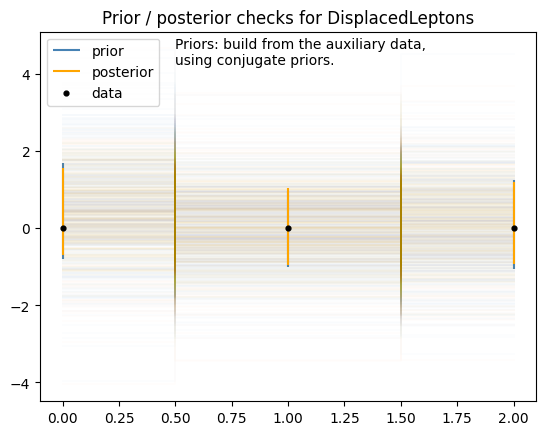

In [5]:
### Plotting ...
    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");
    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")
    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

plt.text(0.5, 4.25, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
# plt.text(10, 1699999, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
plt.title(f'Prior / posterior checks for {n}')

# ax = plt.gca()
# ax.set_ylim([-2099999, 2090999])

# plt.savefig(f'{n}.pdf')

(-2099999.0, 2090999.0)

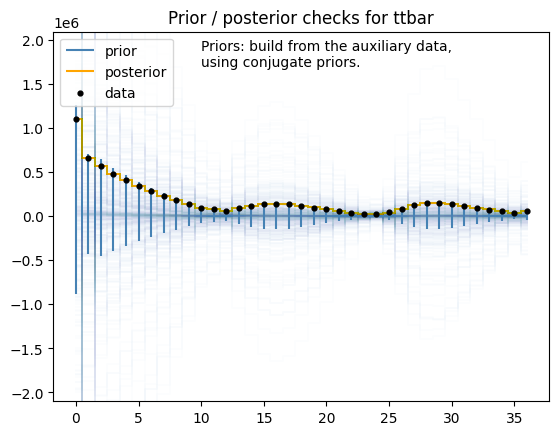

In [9]:
### Plotting ...
    ## Prior predictive
plt.step(np.linspace(0,nBins-1,nBins),prior_data.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(prior_data.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label="prior");
    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.main[0].T, alpha = 0.01, c = 'orange', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.main[0],[.15,.85],axis=0), colors = 'orange', label="posterior")
    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "data")
plt.legend(loc='upper left')

# plt.text(0.5, 4.25, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
plt.text(10, 1699999, 'Priors: build from the auxiliary data, \nusing conjugate priors.')
plt.title(f'Prior / posterior checks for {n}')

ax = plt.gca()
ax.set_ylim([-2099999, 2090999])

# plt.savefig(f'{n}.pdf')